In [1]:
from pyspark import SparkContext
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark import SQLContext
import seaborn as sns
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
import numpy as np
from pylab import rcParams
import pandas as pd
import os
import glob

In [2]:
# Define o estilo para ggplot
plt.style.use("ggplot")

In [3]:
# Criação da sessão Spark
spark = SparkSession \
        .builder \
        .appName('Processo Seletivo - DataSprints') \
        .getOrCreate()

In [4]:
# Criação do contexto Spark SQL   
sqlContext = SQLContext(spark)

Importando arquivos das empresas de Táxi:

In [5]:
vendor = spark.read.option("delimiter", ",").csv(
    "spark-warehouse/datasets/data-vendor.csv", header=True
)

In [6]:
vendor.show()

+---------+--------------------+--------------------+--------+-----+-----+-------+--------------------+-------+
|vendor_id|                name|             address|    city|state|  zip|country|             contact|current|
+---------+--------------------+--------------------+--------+-----+-----+-------+--------------------+-------+
|      CMT|Creative Mobile T...|950 4th Road Suit...|Brooklyn|   NY|11210|    USA|contactCMT@gmail.com|    Yes|
|      VTS|        VeriFone Inc|       26 Summit St.|Flushing|   NY|11354|    USA|   admin@vtstaxi.com|    Yes|
|      DDS|Dependable Driver...|8554 North Homest...|   Bronx|   NY|10472|    USA|          9778896500|    Yes|
|       TS|  Total Solutions Co|Five Boroughs Tax...|Brooklyn|   NY|11229|    USA|       mgmt@5btc.com|    Yes|
|       MT|           Mega Taxi| 4 East Jennings St.|Brooklyn|   NY|11228|    USA|contact@megataxic...|     No|
+---------+--------------------+--------------------+--------+-----+-----+-------+--------------------+-

In [7]:
# Criando a tabela vendor para utilizar nas análises 
vendor.createOrReplaceTempView("vendor");

Criação da tabela que contém o de-para dos pagamentos das viagens:

In [8]:
payment = spark.read.option("delimiter", ",").csv(
    "spark-warehouse/datasets/data-payment.csv", header=True
)

In [9]:
payment.show()

+------------+--------------+
|           A|             B|
+------------+--------------+
|payment_type|payment_lookup|
|         Cas|          Cash|
|         CAS|          Cash|
|         Cre|        Credit|
|         CRE|        Credit|
|         No |     No Charge|
|         Dis|       Dispute|
|        Cash|          Cash|
|        CASH|          Cash|
|      Credit|        Credit|
|      CREDIT|        Credit|
|   No Charge|     No Charge|
|     Dispute|       Dispute|
|         CRD|        Credit|
|         CSH|          Cash|
|         NOC|     No Charge|
|         DIS|       Dispute|
|         UNK|       Unknown|
|           1|           Foo|
|           2|           Foo|
+------------+--------------+
only showing top 20 rows



In [10]:
# Criando a tabela trips 
payment.createOrReplaceTempView("payment");

In [11]:
#  Estrutura da tabela trips a ser criada
fields = [
    StructField("vendor_id", StringType(), True),
    StructField("pickup_datetime", TimestampType(), True),
    StructField("dropoff_datetime", TimestampType(), True),
    StructField("passenger_count", IntegerType(), True),
    StructField("trip_distance", FloatType(), True),
    StructField("pickup_longitude", FloatType(), True),
    StructField("pickup_latitude", FloatType(), True),
    StructField("rate_code", IntegerType(), True),
    StructField("store_and_fwd_flag", FloatType(), True),
    StructField("dropoff_longitude", FloatType(), True),
    StructField("dropoff_latitude", FloatType(), True),
    StructField("payment_type", StringType(), True),
    StructField("fare_amount", FloatType(), True),
    StructField("surcharge", FloatType(), True),
    StructField("tip_amount", FloatType(), True),
    StructField("tolls_amount", FloatType(), True),
    StructField("total_amount", FloatType(), True),
    StructField("duration", IntegerType(), True),
    StructField("month_travel", IntegerType(), True),
    StructField("year_travel", IntegerType(), True),
    StructField("weekday", StringType(), True)
]

schema = StructType(fields)

In [ ]:
path = 'spark-warehouse/datasets/trips-processed'

In [12]:
# Leitura do arquivo processado e salvo no S3 - Foi baixado e adicionado ao projeto pois a integração do Spark com o s3 não funcionou
trips = spark.read.option("delimiter", ";").csv(
    glob.glob(os.path.join(path,'*.csv'), header=True, schema=schema
)

In [14]:
# Removendo dados que contenham datas nulas ou preço da corrida nulo
trips = trips.na.drop(subset=['pickup_datetime', 'dropoff_datetime', 'fare_amount'])

Adicionando algumas variáveis extras que serão úteis nas análises:

In [16]:
# Data sem hora, min e segundos
trips = trips.withColumn('pickup_date', F.date_format(F.col('pickup_datetime'), 'yyy-MM-dd'))

In [17]:
# Abreviação do dia da semana por extenso
trips = trips.withColumn('weekday_day', F.date_format(F.col('pickup_datetime'), 'u'))

In [18]:
# Hora de início da corrida
trips = trips.withColumn('pickup_hour', F.hour(F.col('pickup_datetime')))

In [19]:
# Função que categoriza a corrida em madrugada (dawn), manhã (morning), tarde (evening) e noite (night)
def categorize_period(hour):
    if hour >= 0 and hour < 6:
        return "dawn"
    elif hour >= 6 and hour < 12:
        return "morning"
    elif hour >= 12 and hour < 18:
        return "evening"
    else: 
        return "night"

In [20]:
bucket_udf = F.udf(categorize_period, StringType() )
trips = trips.withColumn("trip_period", bucket_udf("pickup_hour"))

In [24]:
trips.show(5)

+---------+--------------------+--------------------+---------------+-------------+----------------+---------------+---------+------------------+-----------------+----------------+------------+-----------+---------+----------+------------+------------+--------+------------+-----------+-------+-----------+-----------+-----------+-----------+
|vendor_id|     pickup_datetime|    dropoff_datetime|passenger_count|trip_distance|pickup_longitude|pickup_latitude|rate_code|store_and_fwd_flag|dropoff_longitude|dropoff_latitude|payment_type|fare_amount|surcharge|tip_amount|tolls_amount|total_amount|duration|month_travel|year_travel|weekday|pickup_date|weekday_day|pickup_hour|trip_period|
+---------+--------------------+--------------------+---------------+-------------+----------------+---------------+---------+------------------+-----------------+----------------+------------+-----------+---------+----------+------------+------------+--------+------------+-----------+-------+-----------+--------

In [22]:
# Criando a tabela trips 
trips.createOrReplaceTempView("trips");

## Análises

- What is the average distance traveled by trips with a maximum of 2 passengers:

In [25]:
result = sqlContext.sql('SELECT ROUND(AVG(trip_distance),2) AS distancia_media FROM trips WHERE passenger_count <= 2 AND passenger_count > 0')

In [26]:
result.show()

+---------------+
|distancia_media|
+---------------+
|           2.56|
+---------------+



- Which are the 3 biggest vendors based on the total amount of money raised:

In [27]:
result = sqlContext.sql("SELECT name AS empresa, ROUND(SUM(total_amount), 2) AS total_vendas FROM trips t INNER JOIN vendor v ON v.vendor_id = t.vendor_id WHERE passenger_count > 0 GROUP BY empresa ORDER BY total_vendas DESC LIMIT 3")

In [28]:
result.show()

+--------------------+-------------+
|             empresa| total_vendas|
+--------------------+-------------+
|        VeriFone Inc|1.736290919E7|
|Creative Mobile T...|1.626181847E7|
|Dependable Driver...|   2381722.65|
+--------------------+-------------+



- Make a histogram of the monthly distribution over 4 years of rides paid with cash

In [29]:
cash_trips = sqlContext.sql("SELECT month_travel AS month FROM trips WHERE payment_type = 'CASH'")

In [30]:
cash_trips = cash_trips.toPandas()

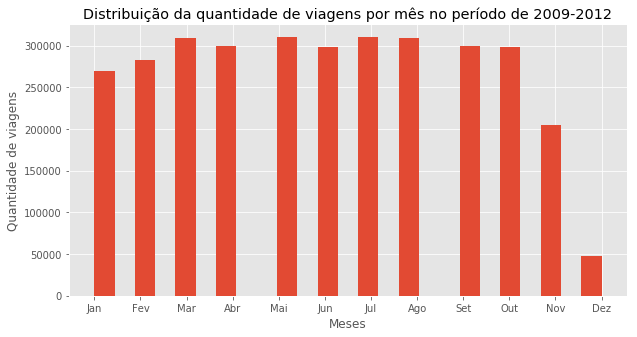

In [31]:
%matplotlib inline
rcParams['figure.figsize'] = 10, 5

cash_trips.hist(bins=25)
plt.xlabel('Meses')
plt.ylabel('Quantidade de viagens')
plt.title("Distribuição da quantidade de viagens por mês no período de 2009-2012")
plt.xticks(np.arange(1,13), ('Jan', 'Fev', 'Mar', 'Abr', 'Mai','Jun','Jul','Ago','Set', 'Out', 'Nov', 'Dez'))
plt.show()

- Make a time series chart computing the number of tips each day for the last 3 months of 2012.

In [32]:
tips_2012 = sqlContext.sql("SELECT year_travel AS year, month_travel AS month, pickup_date as date, COUNT(*) AS trips_with_tip FROM trips WHERE tip_amount > 0.0 AND year_travel = 2012 AND month_travel IN(10,11,12) GROUP BY date, year, month ORDER BY date, year, month")

In [33]:
tips_2012 = tips_2012.toPandas()

In [34]:
tips_2012 = tips_2012.set_index('date')

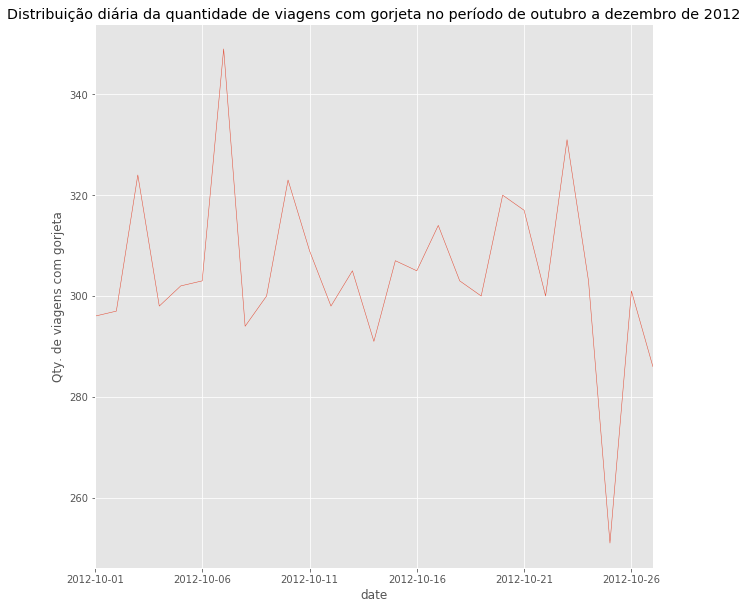

In [35]:
%matplotlib inline

rcParams['figure.figsize'] = 10, 10


plt.xlabel('Data')
plt.ylabel('Qty. de viagens com gorjeta')
plt.title("Distribuição diária da quantidade de viagens com gorjeta no período de outubro a dezembro de 2012")
sns.set(rc={'figure.figsize':(15, 15)})
tips_2012['trips_with_tip'].plot(linewidth=0.5)

- What is the average trip time on Saturdays and Sundays;

In [36]:
average = sqlContext.sql("SELECT weekday AS dia_semana, AVG(duration) AS duracao_media_seg FROM trips WHERE weekday IN('Sat','Sun') GROUP BY weekday")

In [37]:
average = average.toPandas()

In [38]:
average['duracao_media_min'] = (average['duracao_media_seg']/60)

In [39]:
average.head()

,dia_semana,duracao_media_seg,duracao_media_min
0,Sun,525.308953,8.755149
1,Sat,524.719091,8.745318


 -  Analyse the data to find and prove seasonality

- Quantidade de passageiros por viagem

In [40]:
passenger_trips = sqlContext.sql("SELECT qry.num_pass, COUNT(*) AS qtde FROM (SELECT passenger_count AS num_pass FROM trips WHERE passenger_count > 0 ) AS qry GROUP BY qry.num_pass ORDER BY qtde DESC ")

In [41]:
passenger_trips = passenger_trips.toPandas()

In [42]:
passenger_trips

,num_pass,qtde
0,1,2331736
1,2,670312
2,5,322396
3,3,193484
4,4,110996
5,6,15064


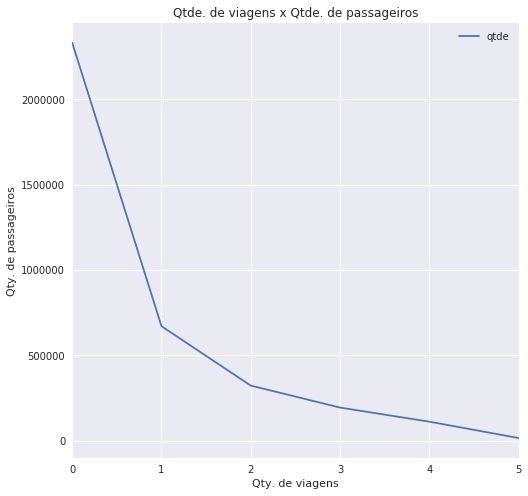

In [53]:
rcParams['figure.figsize'] = 8,8
passenger_trips[['qtde']].plot()
plt.xlabel('Qty. de viagens')
plt.ylabel('Qty. de passageiros')
plt.title("Qtde. de viagens x Qtde. de passageiros")

plt.show()

#### Quantidade de viagens por mês - todos os 4 anos

In [54]:
trips = sqlContext.sql("SELECT year_travel AS year, month_travel AS month, COUNT(*) AS qtde_viagens FROM trips GROUP BY year, month ORDER BY year, month ASC")

In [55]:
trips = trips.toPandas()

In [56]:
trips_month = trips.groupby('month').qtde_viagens.sum().reset_index()

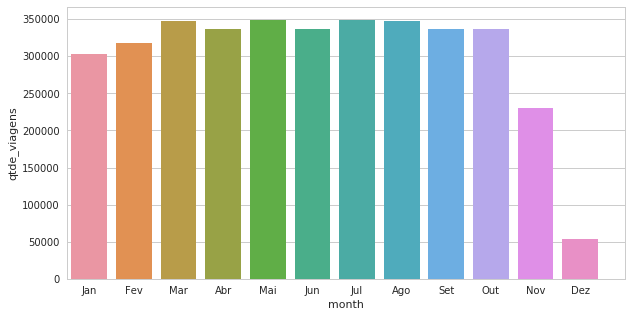

In [57]:
%matplotlib inline
rcParams['figure.figsize'] = 10, 5
sns.set(style="whitegrid")

sns.barplot(x="month", y="qtde_viagens", data=trips_month)
plt.xticks(np.arange(0,13), ('Jan', 'Fev', 'Mar', 'Abr', 'Mai','Jun','Jul','Ago','Set', 'Out', 'Nov', 'Dez'))

plt.show()

##### Quantidade de viagens por mês - Ano de 2009

In [58]:
tm_2009 = trips[(trips['year'] == 2009)]

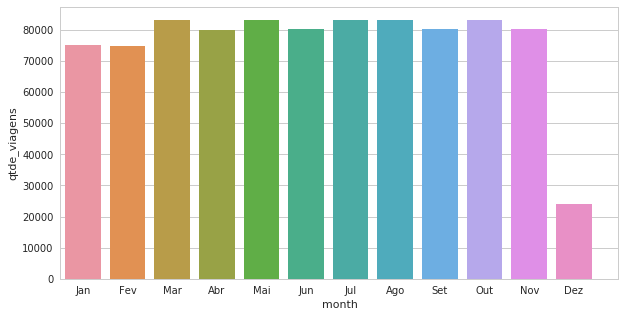

In [59]:
%matplotlib inline
rcParams['figure.figsize'] = 10, 5
sns.set(style="whitegrid")

sns.barplot(x="month", y="qtde_viagens", data=tm_2009)
plt.xticks(np.arange(0,13), ('Jan', 'Fev', 'Mar', 'Abr', 'Mai','Jun','Jul','Ago','Set', 'Out', 'Nov', 'Dez'))

plt.show()

##### Quantidade de viagens por mês - Ano de 2010

In [60]:
tm_2010 = trips[(trips['year'] == 2010)]

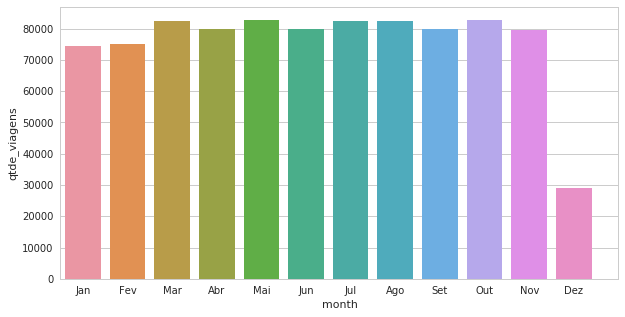

In [61]:
%matplotlib inline
rcParams['figure.figsize'] = 10, 5
sns.set(style="whitegrid")

sns.barplot(x="month", y="qtde_viagens", data=tm_2010)
plt.xticks(np.arange(0,13), ('Jan', 'Fev', 'Mar', 'Abr', 'Mai','Jun','Jul','Ago','Set', 'Out', 'Nov', 'Dez'))

plt.show()

##### Quantidade de viagens por mês - Ano de 2011

In [62]:
tm_2011 = trips[(trips['year'] == 2011)]

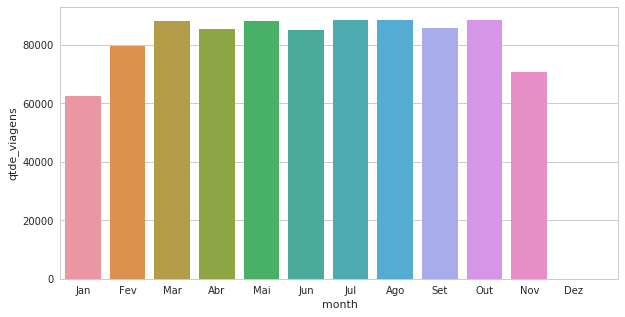

In [63]:
%matplotlib inline
rcParams['figure.figsize'] = 10, 5
sns.set(style="whitegrid")

sns.barplot(x="month", y="qtde_viagens", data=tm_2011)
plt.xticks(np.arange(0,13), ('Jan', 'Fev', 'Mar', 'Abr', 'Mai','Jun','Jul','Ago','Set', 'Out', 'Nov', 'Dez'))

plt.show()

##### Quantidade de viagens por mês - Ano de 2012

In [64]:
tm_2012 = trips[(trips['year'] == 2012)]

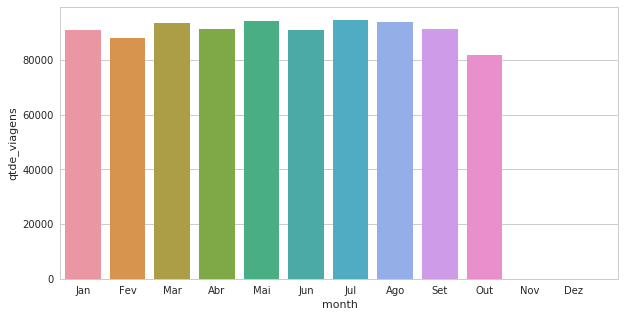

In [65]:
%matplotlib inline
rcParams['figure.figsize'] = 10, 5
sns.set(style="whitegrid")

sns.barplot(x="month", y="qtde_viagens", data=tm_2012)
plt.xticks(np.arange(0,13), ('Jan', 'Fev', 'Mar', 'Abr', 'Mai','Jun','Jul','Ago','Set', 'Out', 'Nov', 'Dez'))

plt.show()

-  7 - Create assumptions, validate against a data and prove with storyelling and graphs

Perfil de viagem dos passageiros

- Horário da viagem x qtde de passageiros

In [66]:
hora_viagem = sqlContext.sql("SELECT COUNT(*) as qtde, passenger_count, trip_period FROM trips WHERE passenger_count >= 1 GROUP BY trip_period,passenger_count ORDER BY qtde DESC")

In [67]:
hora_viagem = hora_viagem.toPandas()

In [68]:
hora_viagem

,qtde,passenger_count,trip_period
0,583929,1,dawn
1,583383,1,morning
2,582401,1,evening
3,582023,1,night
4,168159,2,morning
5,167511,2,evening
6,167333,2,night
7,167309,2,dawn
8,80857,5,night
9,80769,5,dawn


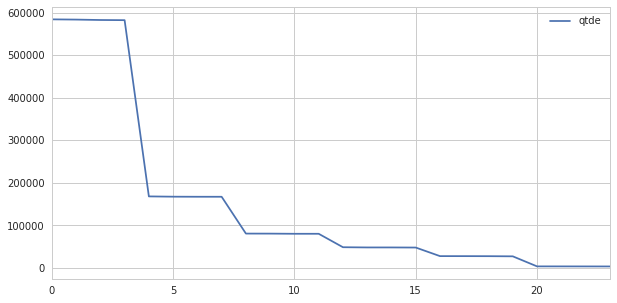

In [69]:
hora_viagem[['qtde','trip_period']].plot()

As pessoas usam menos taxi em feriados? 

R: Em todos os anos analisados, há uma tendência de uma menor utilização de taxis durante os feriados (a quantidade de viagens nesses dias é menor)

Feriados obtidos do site: http://www.public-holidays.us/US_PT_2009_New%20York

In [70]:
feriados_2009 = ['2009-01-01', '2009-01-19', '2009-02-12', '2009-02-16', '2009-05-25','2009-07-04','2009-09-07','2009-10-12', '2009-11-03', '2009-11-26','2009-12-25']

In [71]:
feriados_2010 = ['2010-01-01', '2010-01-18', '2010-02-12', '2010-02-15', '2010-05-31', '2010-07-04','2010-09-06','2010-10-11', '2010-11-02', '2010-11-25', '2010-12-25', '2010-12-31']

In [72]:
feriados_2011 = ['2011-01-01', '2011-01-19', '2011-02-12', '2011-02-16', '2010-05-25', '2010-07-04','2010-09-07','2010-10-12', '2010-11-03', '2010-11-26','2010-12-25']

In [73]:
feriados_2012 = ['2012-01-01', '2012-01-16', '2012-02-12', '2012-02-20', '2012-05-28', '2012-07-04','2012-09-03','2012-10-08', '2012-11-06', '2012-11-22','2012-12-25']

- Ano de 2009

In [74]:
trips_2009 = sqlContext.sql("SELECT * FROM trips WHERE year_travel = 2009")

In [75]:
trips_2009 = trips_2009.toPandas()

In [76]:
trips_2009[(trips_2009['pickup_date'].isin(feriados_2009))].vendor_id.count()

24081

In [77]:
trips_2009[(trips_2009['pickup_date'].isin(feriados_2009))].groupby('pickup_date')['vendor_id'].count()

pickup_date
2009-01-19    2655
2009-02-12    2638
2009-02-16    2712
2009-05-25    2662
2009-07-04    2652
2009-09-07    2744
2009-10-12    2669
2009-11-03    2646
2009-11-26    2703
Name: vendor_id, dtype: int64

In [78]:
mean_feriado = trips_2009[(trips_2009['pickup_date'].isin(feriados_2009))].groupby('pickup_date')['vendor_id'].count().mean()

In [79]:
mean_feriado

2675.6666666666665

In [80]:
trips_2009[~(trips_2009['pickup_date'].isin(feriados_2009))].vendor_id.count()

887026

In [81]:
trips_2009[~(trips_2009['pickup_date'].isin(feriados_2009))].groupby('pickup_date')['vendor_id'].count()

pickup_date
2009-01-04    2713
2009-01-05    2658
2009-01-06    2766
2009-01-07    2676
2009-01-08    2654
2009-01-09    2539
2009-01-10    2719
2009-01-11    2714
2009-01-12    2652
2009-01-13    2728
2009-01-14    2884
2009-01-15    2651
2009-01-16    2717
2009-01-17    2538
2009-01-18    2610
2009-01-20    2732
2009-01-21    2837
2009-01-22    2720
2009-01-23    2627
2009-01-24    2712
2009-01-25    2600
2009-01-26    2654
2009-01-27    2679
2009-01-28    2622
2009-01-29    2632
2009-01-30    2735
2009-01-31    2694
2009-02-01    2637
2009-02-02    2727
2009-02-03    2699
              ... 
2009-11-10    2694
2009-11-11    2696
2009-11-12    2641
2009-11-13    2699
2009-11-14    2742
2009-11-15    2615
2009-11-16    2676
2009-11-17    2639
2009-11-18    2613
2009-11-19    2686
2009-11-20    2742
2009-11-21    2725
2009-11-22    2719
2009-11-23    2638
2009-11-24    2625
2009-11-25    2698
2009-11-27    2639
2009-11-28    2649
2009-11-29    2783
2009-11-30    2683
2009-12-01    2651


In [82]:
media_fora_feriados = trips_2009[~(trips_2009['pickup_date'].isin(feriados_2009))].groupby('pickup_date')['vendor_id'].count().mean()

In [83]:
media_fora_feriados

2671.765060240964

- Ano de 2010

In [84]:
trips_2010 = sqlContext.sql("SELECT * FROM trips WHERE year_travel = 2010")

In [85]:
trips_2010 = trips_2010.toPandas()

In [86]:
trips_2010[(trips_2010['pickup_date'].isin(feriados_2010))].vendor_id.count()

24172

In [87]:
trips_2010[(trips_2010['pickup_date'].isin(feriados_2010))].groupby('pickup_date')['vendor_id'].count()

pickup_date
2010-01-18    2768
2010-02-12    2757
2010-02-15    2667
2010-05-31    2686
2010-07-04    2658
2010-09-06    2671
2010-10-11    2629
2010-11-02    2686
2010-11-25    2650
Name: vendor_id, dtype: int64

In [88]:
trips_2010[(trips_2010['pickup_date'].isin(feriados_2010))].groupby('pickup_date')['vendor_id'].count().mean()

2685.777777777778

In [89]:
trips_2010[~(trips_2010['pickup_date'].isin(feriados_2010))].groupby('pickup_date')['vendor_id'].count()

pickup_date
2010-01-04    2748
2010-01-05    2672
2010-01-06    2589
2010-01-07    2695
2010-01-08    2673
2010-01-09    2601
2010-01-10    2656
2010-01-11    2604
2010-01-12    2727
2010-01-13    2716
2010-01-14    2712
2010-01-15    2671
2010-01-16    2646
2010-01-17    2725
2010-01-19    2621
2010-01-20    2599
2010-01-21    2553
2010-01-22    2611
2010-01-23    2620
2010-01-24    2689
2010-01-25    2647
2010-01-26    2670
2010-01-27    2595
2010-01-28    2667
2010-01-29    2627
2010-01-30    2563
2010-01-31    2704
2010-02-01    2701
2010-02-02    2734
2010-02-03    2630
              ... 
2010-11-12    2720
2010-11-13    2621
2010-11-14    2648
2010-11-15    2644
2010-11-16    2571
2010-11-17    2696
2010-11-18    2661
2010-11-19    2635
2010-11-20    2672
2010-11-21    2674
2010-11-22    2649
2010-11-23    2649
2010-11-24    2740
2010-11-26    2624
2010-11-27    2641
2010-11-28    2608
2010-11-29    2697
2010-11-30    2634
2010-12-01    2631
2010-12-02    2620
2010-12-03    2603


In [90]:
trips_2010[~(trips_2010['pickup_date'].isin(feriados_2010))].groupby('pickup_date')['vendor_id'].count().mean()

2655.494011976048

- Ano de 2011

In [92]:
trips_2011 = sqlContext.sql("SELECT * FROM trips WHERE year_travel = 2011")

In [95]:
trips_2011.filter(trips_2011.pickup_date.isin(feriados_2011)).count()

8419

In [98]:
df = trips_2011.filter(trips_2011.pickup_date.isin(feriados_2011)).groupby('pickup_date').count()

In [100]:
df.show()

+-----------+-----+
|pickup_date|count|
+-----------+-----+
| 2011-02-12| 2801|
| 2011-01-19| 2772|
| 2011-02-16| 2846|
+-----------+-----+



In [106]:
trips_2011.filter(~trips_2011.pickup_date.isin(feriados_2011)).count()

902688

In [107]:
df = trips_2011.filter(~trips_2011.pickup_date.isin(feriados_2011)).groupby('pickup_date').count()

In [108]:
df.show()

+-----------+-----+
|pickup_date|count|
+-----------+-----+
| 2011-01-29| 2854|
| 2011-07-16| 2817|
| 2011-01-27| 2802|
| 2011-01-23| 2829|
| 2011-01-25| 2888|
| 2011-08-16| 2751|
| 2011-06-26| 2836|
| 2011-08-29| 2928|
| 2011-05-06| 2800|
| 2011-02-10| 2835|
| 2011-10-31| 2912|
| 2011-06-07| 2807|
| 2011-09-13| 2876|
| 2011-01-30| 2813|
| 2011-04-11| 2838|
| 2011-04-12| 2767|
| 2011-08-08| 2925|
| 2011-08-28| 2874|
| 2011-02-22| 2934|
| 2011-02-04| 2896|
+-----------+-----+
only showing top 20 rows



- Ano de 2012

In [110]:
trips_2012 = sqlContext.sql("SELECT * FROM trips WHERE year_travel = 2012")

In [111]:
trips_2012.filter(trips_2012.pickup_date.isin(feriados_2012)).count()

21090

In [112]:
df = trips_2012.filter(trips_2012.pickup_date.isin(feriados_2012)).groupby('pickup_date').count()

In [113]:
df.show()

+-----------+-----+
|pickup_date|count|
+-----------+-----+
| 2012-02-20| 3079|
| 2012-09-03| 3071|
| 2012-05-28| 2973|
| 2012-01-16| 3000|
| 2012-02-12| 3049|
| 2012-07-04| 2938|
| 2012-10-08| 2980|
+-----------+-----+



In [114]:
trips_2012.filter(~trips_2012.pickup_date.isin(feriados_2012)).count()

890017

In [115]:
df = trips_2012.filter(~trips_2012.pickup_date.isin(feriados_2012)).groupby('pickup_date').count()

In [116]:
df.show()

+-----------+-----+
|pickup_date|count|
+-----------+-----+
| 2012-03-04| 3055|
| 2012-10-21| 2986|
| 2012-01-12| 2922|
| 2012-03-09| 2995|
| 2012-05-27| 3068|
| 2012-09-05| 3104|
| 2012-05-30| 3084|
| 2012-08-17| 3055|
| 2012-07-06| 3104|
| 2012-01-28| 3088|
| 2012-03-19| 3112|
| 2012-05-12| 3082|
| 2012-06-15| 3148|
| 2012-09-14| 2947|
| 2012-10-06| 2994|
| 2012-08-24| 2941|
| 2012-04-16| 3054|
| 2012-06-29| 3043|
| 2012-05-18| 3087|
| 2012-07-14| 3066|
+-----------+-----+
only showing top 20 rows

